In [3]:
#from IPython.display import Audio, display
#import urllib.request
import numpy as np
#import scipy.stats
#import seaborn as sns
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
#import scikit_posthocs as sp
#import matplotlib.pyplot as plt
#from matplotlib import gridspec
#from matplotlib.transforms import BlendedGenericTransform
#import scikit_posthocs as sp
#from urllib.request import urlopen
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [10]:
def draw(fname, path):
    wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\" + path + "\\" + fname)
    fft = librosa.stft(wav, hop_length=256, n_fft=1024)
    print (path)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')
    return fft


clean
(513, 239)


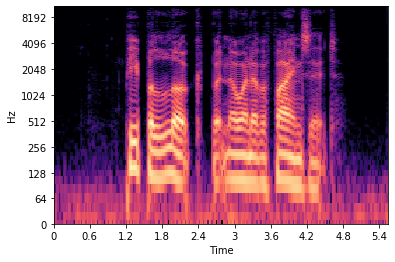

In [11]:
wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\clean\\p232_010.wav")

c_f = draw("p232_010.wav", "clean")

print(c_f.shape)

rewav = librosa.istft(c_f, hop_length=256)

Audio(rewav, rate=rate)


noisy


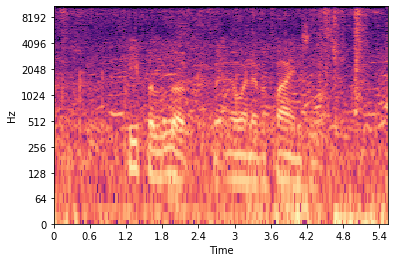

In [13]:
n_f = draw("p232_010.wav", "noisy")

In [24]:
# polar experiments
import cmath

n_f_m = abs(n_f)
c_f_m = abs(c_f)

mag_ratio = c_f_m/n_f_m

re_f = n_f * mag_ratio

rewav = librosa.istft(re_f, hop_length=256)

Audio(rewav, rate=rate)

# this works for full complex numbers
#diff = n_f - c_f
#reclean = n_f - diff
#real_clean = c_f.real + 1j * c_f.imag


In [12]:
Audio(wav, rate=rate)


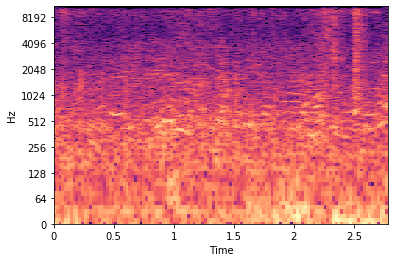

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(diff), ref=np.max), y_axis='log', x_axis='time')

In [38]:
round_trip = librosa.istft(real_clean)
Audio(round_trip, rate=rate)

In [29]:
round_trip = librosa.istft(X)
Audio(round_trip, rate=rate)

(768, 239)


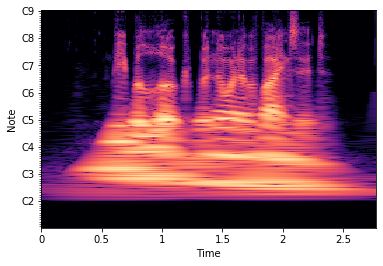

In [6]:
# CQT experiments

hop_length = 256
bins_per_octave = 12 * 8
fmin = librosa.note_to_hz('C1')
octaves = 8
C = librosa.cqt(wav, hop_length=hop_length, fmin=fmin, n_bins=octaves*bins_per_octave, bins_per_octave=bins_per_octave)
print(C.shape)

C[0:bins_per_octave,:] = 0
fade = bins_per_octave//2
for i in range(0,fade):
    C[bins_per_octave+i,:] = (i/fade) * C[bins_per_octave+i,:]

rewav = librosa.icqt(C, hop_length=hop_length, bins_per_octave=bins_per_octave)


librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max), y_axis='cqt_note', x_axis='time', hop_length=hop_length, fmin=fmin,  bins_per_octave=bins_per_octave)


Audio(rewav, rate=rate)
